In [35]:
import numpy as np
import pandas as pd 
'''
Pandas是Python的一个数据分析包，该工具为解决数据分析任务而创建。
Pandas纳入大量库和标准数据模型，提供高效的操作数据集所需的工具。
'''
#内嵌绘图
%matplotlib inline
#绘图框架
import matplotlib.pyplot as plt
#里面有很多颜色映射表
import matplotlib.cm as cm

import tensorflow as tf
import sys

#学习率
LEARNING_RATE = 1e-4
#迭代次数
TRAINING_ITERATIONS = 2500

#解决过拟合 保留神经元的比例
DROPOUT = 0.5
BATCH_SIZE = 50

#验证的数据量
VALIDATION_SIZE = 2000

#迭代多少次展示一次效果
IMAGE_TO_DISPLAY = 10

In [36]:
data = pd.read_csv('train.csv')  # pandas.core.frame.DataFrame
print('data({0[0]},{0[1]})'.format(data.shape))  # 42000条数据 每条数据有785个数据   string.format  使用索引
print(data.head()) #默认参数为5 取前五条

data(42000,785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0   

### 可以看出整个数据分为 1列 label 和 784列 piexel值

# 1.对图像进行操作 转换成标准的图像形式

In [54]:
images= data.iloc[:,1:].values #将图像数据选择出来  取出作为 dnarray 形式

#image 像素点的值 归一化
#images = images.astype(np.float) #数据类型转换  省略也可以
images = np.multiply(images,1.0/255.0) 

print('images({0[0]},{0[1]})'.format(images.shape))  #images就是一幅一幅图构成的ndarray

images(42000,784)


In [55]:
image_size = images.shape[1] #图像大小
print('image_size => {0}'.format(image_size))

image_width = image_height = np.sqrt(image_size).astype(np.uint8) # np.ceil 向正无穷方向取整  unit8 范围:0~255 

print('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))


image_size => 784
image_width => 28
image_height => 28


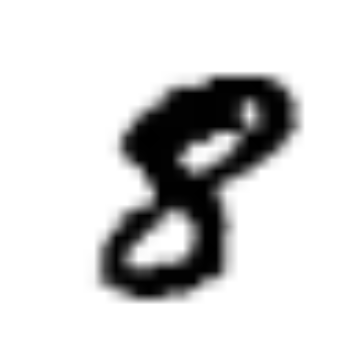

In [56]:
# 此时的图像数据是一条一条的  要转换成图像的标准形式并展示 
def display(img):
    one_image = img.reshape(image_width,image_height)
    #展示
    plt.axis('off') #不显示坐标
    plt.imshow(one_image,cmap=cm.binary)

display(images[IMAGE_TO_DISPLAY])  # 数据集提供的 测试能否展示的用的数据  此时也可以写images[0]。。。

# 2.对label进行操作

In [57]:
#data['label'].values
#data[[0,1]]  选取列可以直接这样  如果要选择某行到某行 需要使用切片

In [58]:
labels_flat = data[[0]].values.ravel()  # 将原本高维的label数组 转换成一维数组

print('labels_flat({0})'.format(len(labels_flat)))
print('labels_flat[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels_flat[IMAGE_TO_DISPLAY]))

labels_flat(42000)
labels_flat[10] => 8


In [59]:
#得出label 一共有多少种
labels_count = np.unique(labels_flat).shape[0]  # np.unique 去重 再排序

print('labels_count => {0}'.format(labels_count))

labels_count => 10


In [60]:
# 将labels转换成 one_hot 
def dense_to_one_hot(labels_dense,num_classes):
    num_labels = labels_dense.shape[0] #42000
    index_offset = np.arange(num_labels) * num_classes # np.arange 向量的形式
    labels_one_hot = np.zeros((num_labels,num_classes)) #二维数组
    #拉平 在之前labels_flat
    labels_one_hot.flat[index_offset + labels_dense] = 1
    return labels_one_hot
labels = dense_to_one_hot(labels_flat,labels_count)
labels = labels.astype(np.uint8)

In [61]:
print('labels({0[0]},{0[1]})'.format(labels.shape))
print('labels[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels[IMAGE_TO_DISPLAY]))

labels(42000,10)
labels[10] => [0 0 0 0 0 0 0 0 1 0]


In [63]:
# 将数据集分成训练集和测试机
validation_images = images[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]

print('train_images({0[0]},{0[1]})'.format(train_images.shape))
print('validation_images({0[0]},{0[1]})'.format(validation_images.shape))

train_images(40000,784)
validation_images(2000,784)


# 3.数据预处理完成 进行调参

In [66]:
#对权重参数与偏置参数进行初始化
def weight_variable(shape):
    initial = tf.truncated_normal(shape,stddev=0.1) #truncated_normal 正态分布产生随机数据  stddev  标准差 
    return tf.Variable(initial) #定义图变量

def bias_variable(shape):
    initial = tf.constant(0.1,shape=shape)
    return tf.Variable(initial)

Tensor("truncated_normal_2:0", shape=(10, 0), dtype=float32)
<tf.Variable 'Variable_2:0' shape=(10, 0) dtype=float32_ref>


In [12]:
# 卷积操作
def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')  # stride[batch_size,height,width,channel] 主要是改变中间两个变量

In [13]:
#池化操作
def max_pool_2x2(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME') # ksize 多大的矩阵进行池化

In [14]:
#输入
#images
x = tf.placeholder('float',shape=[None,image_size])
#labels
y_ = tf.placeholder('float',shape=[None,labels_count])

In [15]:
#第一层卷积
W_conv1 = weight_variable([5,5,1,32]) #5，5 filter的h和w 1表示channel 32表示 32个filter
b_conv1 = bias_variable([32])

# (40000,784) -> (40000,28,28,1)
image = tf.reshape(x,[-1,image_width,image_height,1])

h_conv1 = tf.nn.relu(conv2d(image,W_conv1)+b_conv1)
# (40000,28,28,32)

h_pool1 = max_pool_2x2(h_conv1)
#(40000,14,14,32)

In [16]:
#第二层卷积
W_conv2 = weight_variable([5,5,32,64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1,W_conv2)+b_conv2)
#(40000,14,14,64)
h_pool2 = max_pool_2x2(h_conv2)
#（40000，7，7，64）

In [17]:
#全连接操作  
W_fc1 = weight_variable([7*7*64,1024])  #转换成1024维的向量   定义权重参数
b_fc1 = bias_variable([1024])

#将原本三维立体的图 拉成一维向量  （40000，3136）
h_pool2_flat = tf.reshape(h_pool2,[-1,7*7*64])  # -1 是python中的一种自动计算的表达

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat,W_fc1) + b_fc1)   #矩阵乘法
# (40000,1024)

In [18]:
# dropout
keep_prob = tf.placeholder('float')  #此函数可以理解为形参，用于定义过程，在执行的时候再赋具体的值
h_fc1_drop = tf.nn.dropout(h_fc1,keep_prob)

In [19]:
W_fc2 = weight_variable([1024,labels_count])
b_fc2 = bias_variable([labels_count])

y = tf.nn.softmax(tf.matmul(h_fc1_drop,W_fc2)+b_fc2) #得到10分类的概率值
#（40000，10）

In [20]:
cross_entropy = -tf.reduce_sum(y_*tf.log(y)) #损失值

#优化
train_step = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(cross_entropy)

#evaluation 评估  正确的百分率
correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction,'float'))

In [21]:
predict = tf.argmax(y,1)

In [27]:
#迭代
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

def next_batch(batch_size):
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    
    if index_in_epoch > num_examples:
        epochs_completed += 1
        
        #shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
            
        #start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end],train_labels[start:end]

In [28]:
#start TensorFlow session
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()

sess.run(init)

D:\Anaconda3-4.2.0\lib\site-packages\tensorflow\python\client\session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
train_accuracies = []
validation_accuracies = []
x_range = []

display_step=1

for i in range(TRAINING_ITERATIONS):
    #get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)
    
    #每隔多少次 展示一次
    if i%display_step ==0 or (i+1) == TRAINING_ITERATIONS:
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs,
                                                  y_: batch_ys,
                                                  keep_prob: 1.0}) # keep_prob 保留率
    
        if(VALIDATION_SIZE):
            validation_accuracy = accuracy.eval(feed_dict={x:validation_images[0:BATCH_SIZE],
                                                          y_:validation_labels[0:BATCH_SIZE],
                                                          keep_prob:1.0})
            print('training_arracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy,validation_accuracy,i))
            
            validation_accuracies.append(validation_accuracy)
        
        else:
            print('training_accuracy => %.4f for step %d'%(train_accuracy,i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        
        # increase display_step
        if i%(display_step*10) == 0 and i:
            display_step *= 10
    #train on batch
    sess.run(train_step,feed_dict={x:batch_xs,y_:batch_ys,keep_prob:DROPOUT})
    

training_arracy / validation_accuracy => 0.06 / 0.10 for step 0
training_arracy / validation_accuracy => 0.12 / 0.12 for step 1
training_arracy / validation_accuracy => 0.20 / 0.22 for step 2
training_arracy / validation_accuracy => 0.28 / 0.32 for step 3
